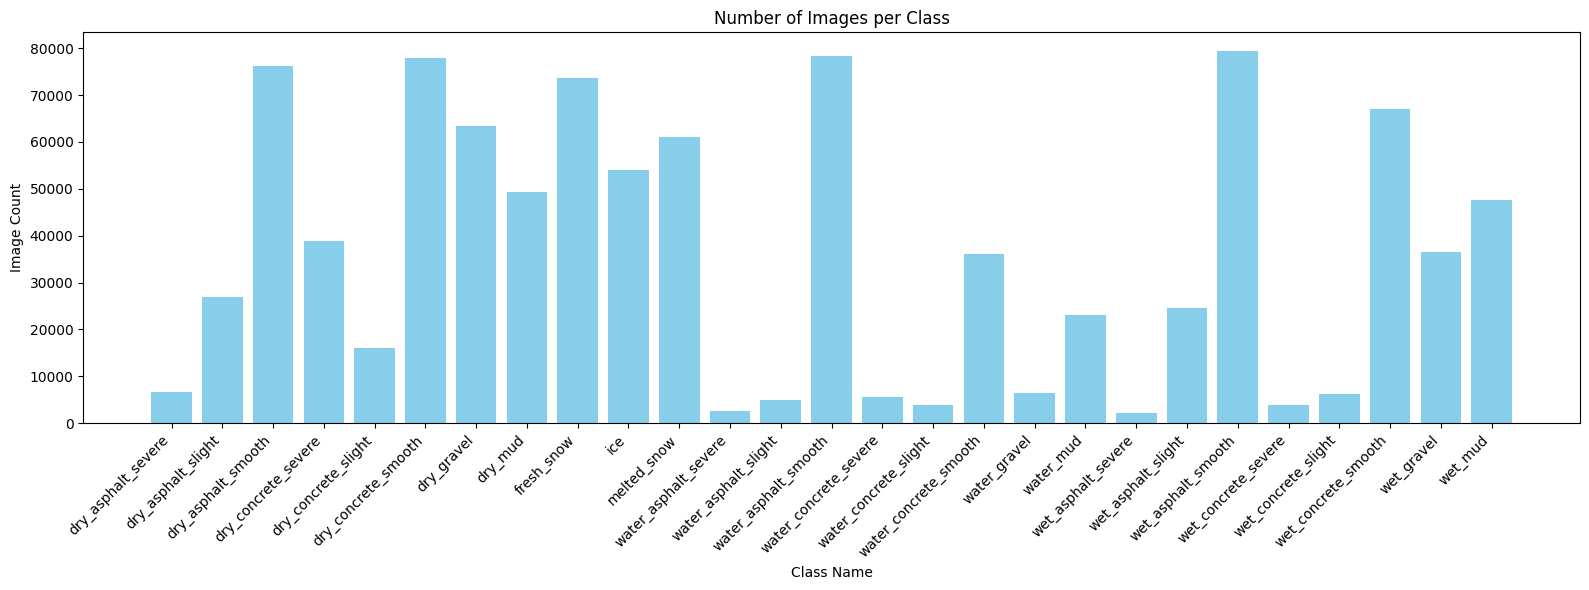

In [4]:
import os
import matplotlib.pyplot as plt

dataset_dir = 'RSCD/RSCD_dataset/train'  # or your actual path
class_counts = {}

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = count

# Sort by class name for consistency
class_counts = dict(sorted(class_counts.items()))

# Plot
plt.figure(figsize=(16, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Number of Images per Class")
plt.ylabel("Image Count")
plt.xlabel("Class Name")
plt.tight_layout()
plt.show()


In [1]:
import os
import cv2
import random
import albumentations as A
import numpy as np
from tqdm import tqdm
from uuid import uuid4
import logging
import shutil

# Logging setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("DatasetBalancer")

# Configs
ROOT_INPUT_DIR = 'RSCD/RSCD_dataset/train'
ROOT_OUTPUT_DIR = 'RSCD/RSCD_dataset/train_50k'
TARGET_COUNT = 50000
IMAGE_SIZE = 224

# Preprocessing pipeline for quality ranking
clarity_preprocess = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE)
])

# Augmentation pipeline for underrepresented classes
augmentor = A.Compose([
    A.RandomResizedCrop((IMAGE_SIZE,IMAGE_SIZE), scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.MotionBlur(p=0.2),
    A.RandomShadow(p=0.2),
    A.RandomRain(p=0.1),
    A.RandomSnow(p=0.1),
    A.CLAHE(p=0.3),
    A.GaussianBlur(p=0.1),
    A.Normalize()
])

def calculate_clarity(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def save_image(img, output_dir, prefix):
    filename = f"{prefix}_{uuid4().hex}.jpg"
    path = os.path.join(output_dir, filename)
    cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Process each class folder
for class_name in sorted(os.listdir(ROOT_INPUT_DIR)):
    input_dir = os.path.join(ROOT_INPUT_DIR, class_name)
    output_dir = os.path.join(ROOT_OUTPUT_DIR, class_name)
    os.makedirs(output_dir, exist_ok=True)

    if not os.path.isdir(input_dir):
        continue

    image_files = [os.path.join(input_dir, f)
                   for f in os.listdir(input_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    logger.info(f"Processing class '{class_name}' with {len(image_files)} images")

    if len(image_files) >= TARGET_COUNT:
        clarity_scores = []
        for img_path in tqdm(image_files, desc=f"Scoring {class_name}"):
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = clarity_preprocess(image=img)['image']
                score = calculate_clarity(img)
                clarity_scores.append((score, img_path))
            except Exception as e:
                logger.warning(f"Error reading image {img_path}: {e}")
        clarity_scores.sort(reverse=True, key=lambda x: x[0])
        top_images = clarity_scores[:TARGET_COUNT]

        for i, (_, path) in enumerate(tqdm(top_images, desc=f"Copying top 25k")):
            try:
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                transformed = clarity_preprocess(image=img)['image']
                save_image(transformed, output_dir, "cleaned")
            except Exception as e:
                logger.warning(f"Error saving image {path}: {e}")

    else:
        copied = 0
        for path in image_files:
            try:
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                transformed = clarity_preprocess(image=img)['image']
                save_image(transformed, output_dir, "copied")
                copied += 1
            except Exception as e:
                logger.warning(f"Error copying image {path}: {e}")
        logger.info(f"Generating {TARGET_COUNT - copied} images for '{class_name}'")
        while copied < TARGET_COUNT:
            source_path = random.choice(image_files)
            img = cv2.imread(source_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            try:
                aug = augmentor(image=img)['image']
                save_image(aug, output_dir, "augmented")
                copied += 1
            except Exception as e:
                logger.warning(f"Error augmenting {source_path}: {e}")

logger.info("Dataset balancing complete. Each class has exactly 50,000 images.")


INFO:DatasetBalancer:Processing class 'dry_asphalt_severe' with 6610 images
INFO:DatasetBalancer:Generating 43390 images for 'dry_asphalt_severe'
[ WARN:0@9.793] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.
INFO:DatasetBalancer:Processing class 'dry_asphalt_slight' with 27023 images
INFO:DatasetBalancer:Generating 22977 images for 'dry_asphalt_slight'
INFO:DatasetBalancer:Processing class 'dry_asphalt_smooth' with 76231 images
Copying top 25k: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:58<00:00, 861.23it/s]
INFO:DatasetBalancer:Processing class 'dry_concrete_severe' with 38850 images
INFO:DatasetBalancer:Generating 11150 images for 'dry_concrete_severe'
INFO:DatasetBalancer:Processing class 'dry_concrete_slight' with 16092 images
INFO:DatasetBalancer:Generating 33908 images for 'dry_concrete_slight'
INFO:DatasetBalancer:Processing class 'dry_concrete_smoot

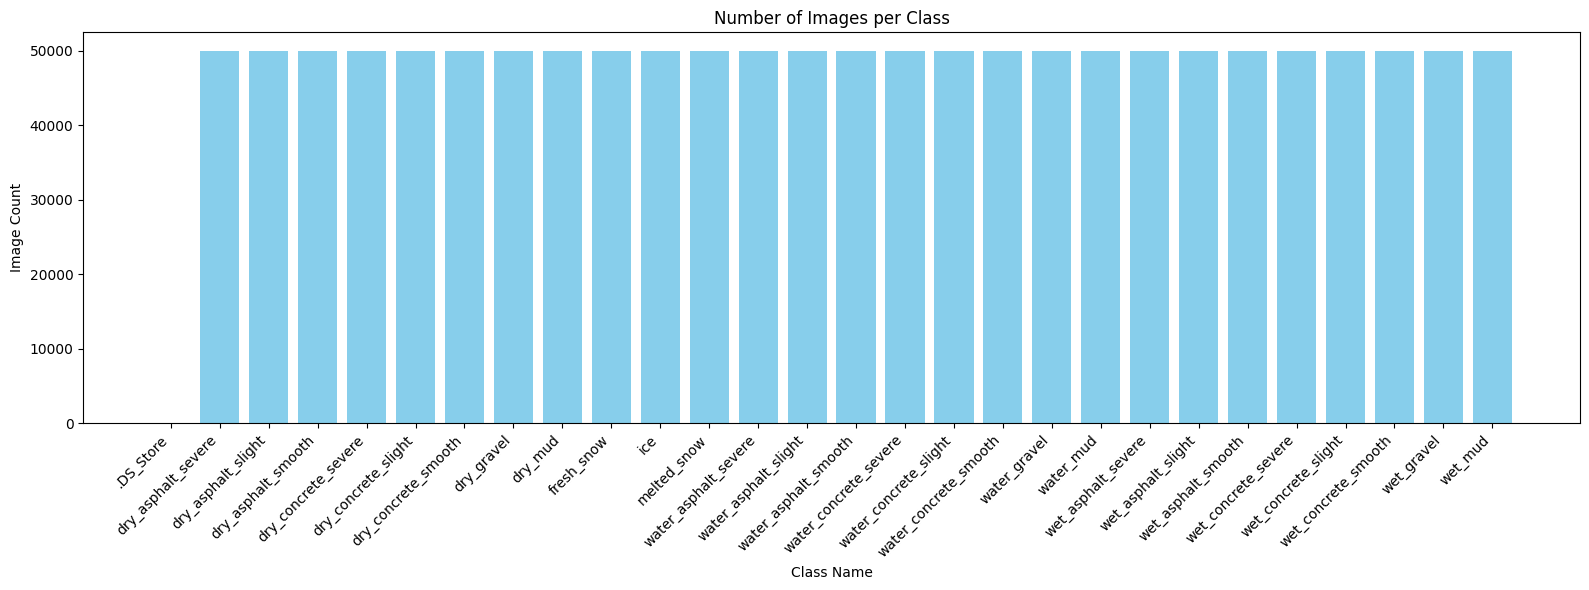

In [2]:
import os
import matplotlib.pyplot as plt

dataset_dir = 'RSCD/RSCD_dataset/train_50k'
class_counts = {}

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        class_counts[class_name] = count

class_counts = dict(sorted(class_counts.items()))

plt.figure(figsize=(16, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Number of Images per Class")
plt.ylabel("Image Count")
plt.xlabel("Class Name")
plt.tight_layout()
plt.savefig('RSCD/')
plt.show()